In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Add
from keras.utils.vis_utils import plot_model

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l 

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import os

from matplotlib.ticker import FormatStrFormatter

import time
np.random.seed(2023)

In [2]:
print(os.getcwd())

/content


In [3]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados/Experimento Imagenes Adversarias A')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados/Experimento Imagenes Adversarias A


In [4]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [5]:
def load_data():
  mnist = keras.datasets.mnist
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train, X_test = X_train / 255.0, X_test / 255.0
  X_train = X_train.reshape(len(y_train),784)
  X_test  = X_test.reshape(len(y_test),784)

  y_train_onehot = keras.utils.to_categorical(y_train)
  y_test_onehot =  keras.utils.to_categorical(y_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño imágenes de entrenamiento {X_train[:10000].shape}')
  print(f'Tamaño imágenes de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train[:10000])}')
  return X_train[:10000], X_test, y_train_onehot[:10000], y_test_onehot, y_train[:10000], y_test

In [6]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

11490434/11490434 [==============================] - 0s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento (10000, 784)
Tamaño imágenes de test (10000, 784)
Datos por cada etiqueta en X train [1001 1127  991 1032  980  863 1014 1070  944  978]


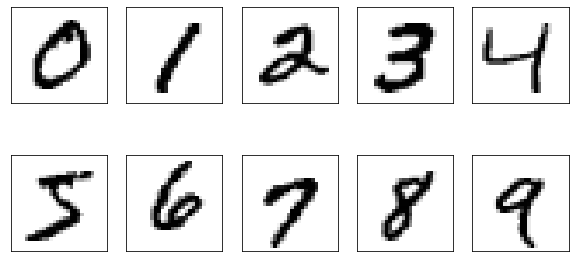

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gist_yarg')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

## Modelo con $n$ saltos residuales

In [8]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  return Add()([dense_input, resDenseo])

In [9]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20, activation  ='relu', kernel_regularizer=regular_l)(inputs)
  
  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
      
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [11]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=100, shuffle=True)
n_batches = len(generator)
n_batches

100

In [12]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try: 
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1
  
  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar 

In [13]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.grid()
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  nameFile = 'presicionModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


In [14]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()

In [15]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0),
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [16]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold - Entrenamiento Convencional

In [17]:
skips = [4,6,8]
n_epochs = 60
resultGeneral = {}
modelConvencional = {}

for skip in skips:
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
  generator = DataGenerator(images=X_train, 
                            labels=y_train, 
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  
  model = load_model(skip,l.l2(0))

  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))
  
  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
    for batch in range(n_batches):
      x, y = generator[batch]

      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
      
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB = lipschitz_bound(model.get_weights())
    LB_1[epoch]= LB

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1))
    
  resultGeneral[skip] = [acc_train, acc_test, LB_1]
  modelConvencional[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoAadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos 

In [18]:
for skip in skips:
  mean_test = resultGeneral[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.42
Modelo 6, test 91.93
Modelo 8, test 91.20


### Evaluación en entrenamiento de los modelos

In [19]:
for skip in skips:
  mean_train = resultGeneral[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 96.42
Modelo 6, train 97.80
Modelo 8, train 97.10


### Evaluación con imágenes adversarias

In [20]:
def fsgm_attack(x,y, model):
  with tf.GradientTape() as tape:
      prediction = model(x)
      loss = loss_function(y, prediction)
  gradient = tape.gradient(loss, x)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [21]:
def scale_image(x):
  m = 1/(np.max(x) - np.min(x))
  b = -1*m*np.min(x)
  return m*x + b*np.ones(len(x))

In [22]:
def graph_digits(X, y):
  fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

  ax = ax.flatten()
  for i in range(10):
      img = X[y == i][0].reshape(28, 28)
      ax[i].imshow(img, cmap='gist_yarg')

  ax[0].set_xticks([])
  ax[0].set_yticks([])

  plt.show()

Imagenes originales


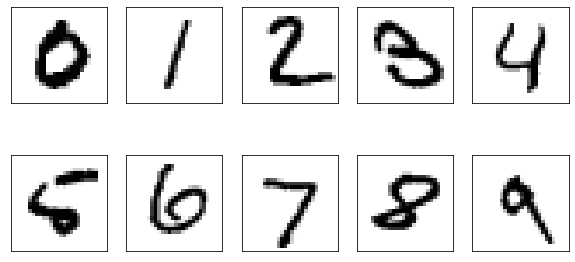

Imagenes perturbación 0.01


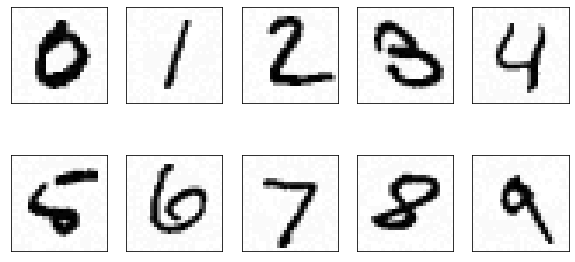

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


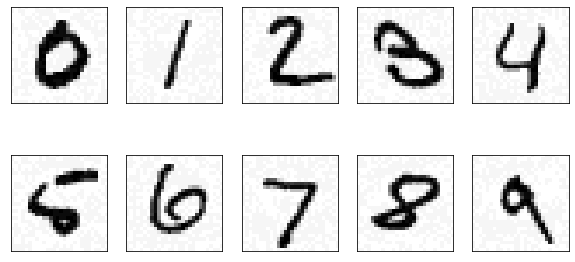

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.03


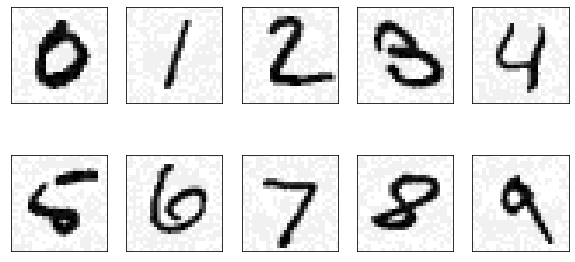

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.01


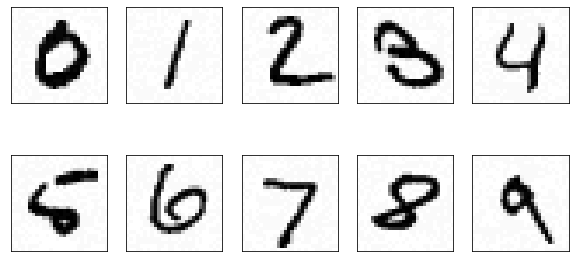

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


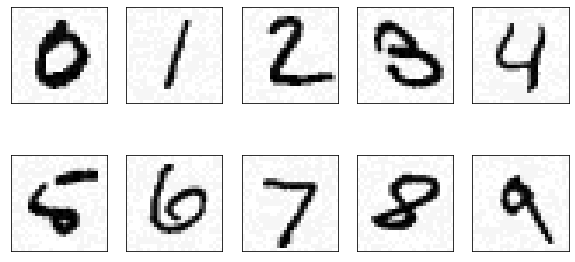

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


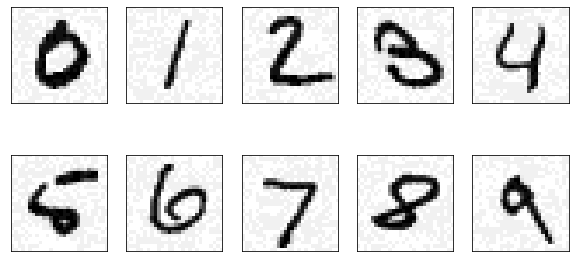

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


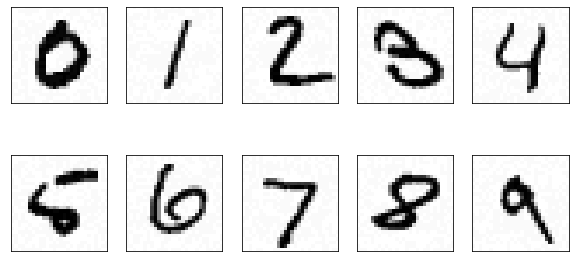

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


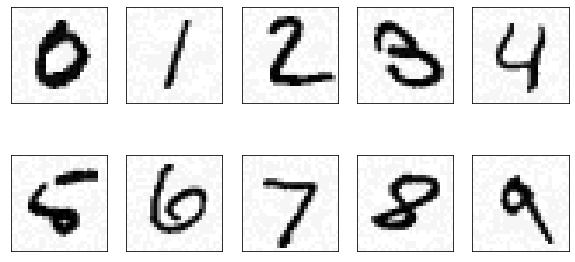

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


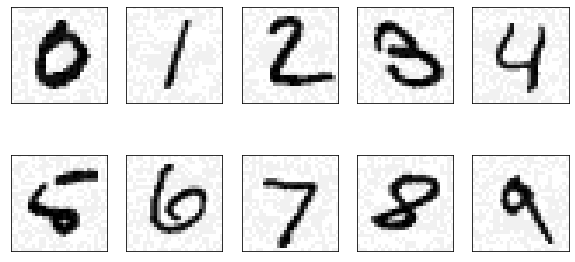

32/32 [==============================] - 0s 1ms/step


In [23]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}
for skip in skips:
  Eval_models_by_rho = {}
  rhos = [0.01, 0.02, 0.03]
  model = modelConvencional[skip]
  for rho in rhos:
    X_test_atack = np.zeros((1000,784))
    i = 0
    for x_test in X_test[0:1000]:
      x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
      x_tensor1 = tf.expand_dims(x_tensor1, axis=0)
      
      y_tensor1 = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
      y_tensor1 = tf.expand_dims(y_tensor1, axis=0)
    
      y_tensor = y_tensor1
      x_tensor = x_tensor1
      del x_tensor1, y_tensor1
      
      x = tf.Variable(x_tensor)
      y = tf.Variable(y_tensor)
      del x_tensor, y_tensor

      signed_grad = fsgm_attack(x,y,model)

      signo_grad = np.array(signed_grad)
      x_test_new = x_test + rho*signo_grad
      
      X_test_atack[i] = scale_image(x_test_new)
      i +=1 
    print(f'Imagenes perturbación {rho}')
    graph_digits(X_test_atack, y_test[0:1000])
    y_ = model.predict(X_test_atack) # Validation predictions
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_, axis=-1))
    Eval_models_by_rho[rho] = Eval_models
    del Eval_models
  Eval_models_by_rho_skip[skip] = Eval_models_by_rho
  del Eval_models_by_rho

In [24]:
for skip in skips:
  for rho in rhos:
    print(f'Modelo {skip}, perturbación {rho}, % presición {Eval_models_by_rho_skip[skip][rho]*100:0.2f}')

Modelo 4, perturbación 0.01, % presición 74.80
Modelo 4, perturbación 0.02, % presición 46.90
Modelo 4, perturbación 0.03, % presición 24.40
Modelo 6, perturbación 0.01, % presición 70.40
Modelo 6, perturbación 0.02, % presición 44.20
Modelo 6, perturbación 0.03, % presición 23.40
Modelo 8, perturbación 0.01, % presición 64.70
Modelo 8, perturbación 0.02, % presición 34.30
Modelo 8, perturbación 0.03, % presición 18.20


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización Alternante cota Lipschitz

In [25]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, Model = None, name="adaptativeRegularLB"):
        super().__init__(name=name)
        self.Model = Model

    def call(self, y_true, y_pred):
        self.Model._callable_losses.clear()
        cce = tf.keras.losses.CategoricalCrossentropy()
        loss = tf.cast(cce(y_true, y_pred), "float32")
        self.eig_values_radom(self.Model)
        loss += sum(self.Model.losses)
        return  loss 

    def eig_values_radom(self, Model):
      allLayers = self.Model.layers
      nLayers = len(allLayers)
      randomLayer = np.random.choice(np.append([1], [np.arange(2,nLayers,2)]), size=1)[0]
      EigVal = np.linalg.norm(allLayers[randomLayer].get_weights()[0], ord=2)
      self.Model.add_loss(lambda: EigVal*tf.norm(allLayers[randomLayer].trainable_variables[0], ord=2))
      #self.Model.add_loss(lambda: EigVal*tf.reduce_sum(tf.square(allLayers[randomLayer].trainable_variables[0])))
      return 

In [26]:
skips = [4,6,8]
n_epochs = 60
resultGeneralLB = {}
modelLB = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
  generator = DataGenerator(images=X_train, 
                            labels=y_train, 
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,l.l2(0))

  
  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))
  
  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
    for batch in range(n_batches):
      x, y = generator[batch]

      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        lossC = CustomLoss(Model = model)
        loss = lossC(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
      
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
    generator.on_epoch_end()
    
    acc_train[epoch] = epoch_acc_avg.result()

    LB = lipschitz_bound(model.get_weights())
    LB_1[epoch]= LB

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=np.argmax(y_test_, axis=-1))
  resultGeneralLB[skip] = [acc_train, acc_test, LB_1]
  modelLB[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralLB), 'ResultadosExperimentoALBadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos 

In [27]:
for skip in skips:
  mean_test = resultGeneralLB[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 89.21
Modelo 6, test 90.95
Modelo 8, test 92.14


### Evaluación en entrenamiento de los modelos

In [28]:
for skip in skips:
  mean_train = resultGeneralLB[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 90.22
Modelo 6, train 93.04
Modelo 8, train 94.99


### Evaluación con imágenes adversarias

Imagenes originales


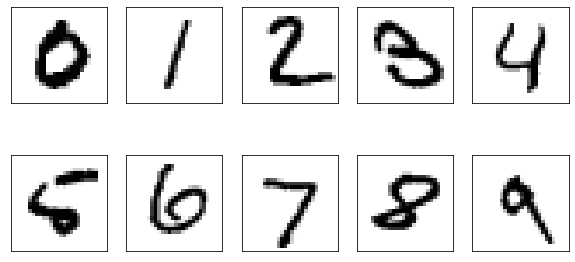

Imagenes perturbación 0.01


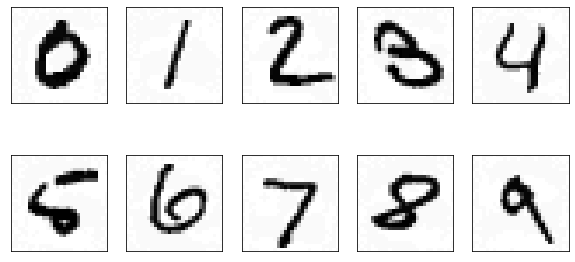

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.02


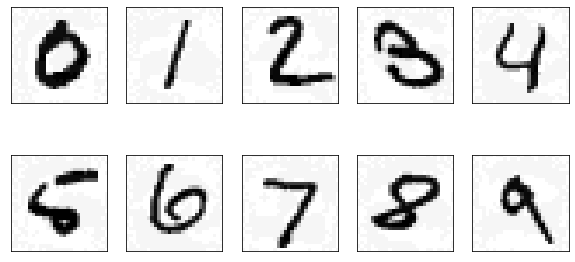

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


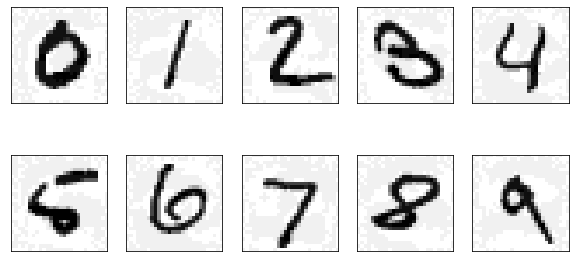

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.01


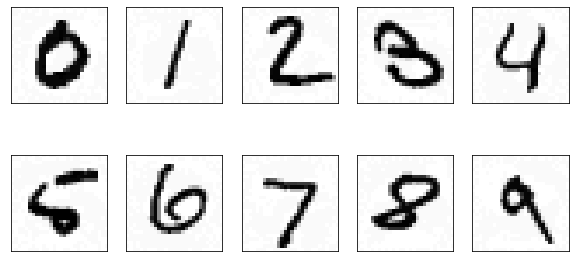

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.02


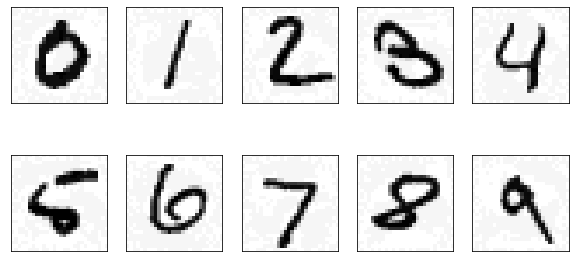

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


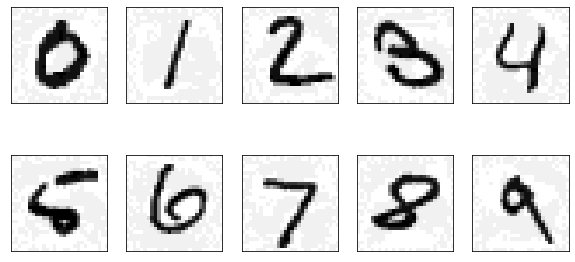

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.01


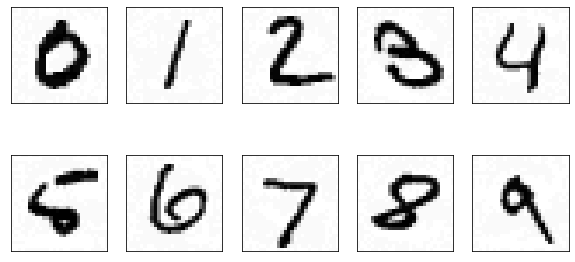

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


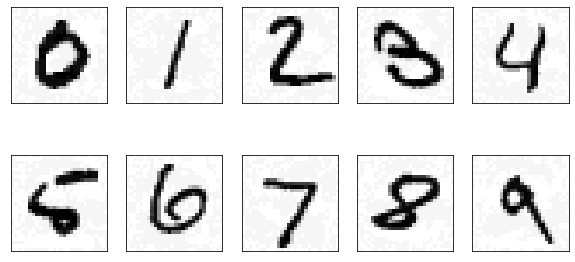

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


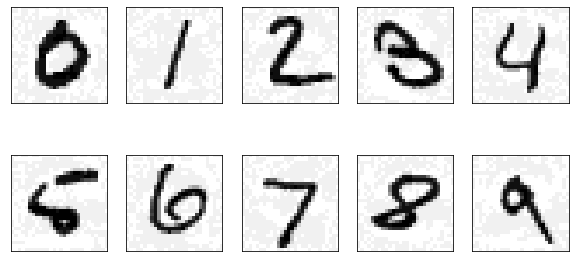

32/32 [==============================] - 0s 2ms/step


In [29]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}
for skip in skips:
  Eval_models_by_rho = {}
  rhos = [0.01, 0.02, 0.03]
  model = modelLB[skip]
  for rho in rhos:
    X_test_atack = np.zeros((1000,784))
    i = 0
    for x_test in X_test[0:1000]:
      x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
      x_tensor1 = tf.expand_dims(x_tensor1, axis=0)
      
      y_tensor1 = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
      y_tensor1 = tf.expand_dims(y_tensor1, axis=0)
    
      y_tensor = y_tensor1
      x_tensor = x_tensor1
      del x_tensor1, y_tensor1
      
      x = tf.Variable(x_tensor)
      y = tf.Variable(y_tensor)
      del x_tensor, y_tensor

      signed_grad = fsgm_attack(x,y,model)

      signo_grad = np.array(signed_grad)
      x_test_new = x_test + rho*signo_grad
      
      X_test_atack[i] = scale_image(x_test_new)
      i +=1 
    print(f'Imagenes perturbación {rho}')
    graph_digits(X_test_atack, y_test[0:1000])
    y_ = model.predict(X_test_atack) # Validation predictions
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_, axis=-1))
    Eval_models_by_rho[rho] = Eval_models
    del Eval_models
  Eval_models_by_rho_skip[skip] = Eval_models_by_rho
  del Eval_models_by_rho

In [30]:
for skip in skips:
  for rho in rhos:
    print(f'Modelo {skip}, perturbación {rho}, % presición {Eval_models_by_rho_skip[skip][rho]*100:0.2f}')

Modelo 4, perturbación 0.01, % presición 83.40
Modelo 4, perturbación 0.02, % presición 77.70
Modelo 4, perturbación 0.03, % presición 70.20
Modelo 6, perturbación 0.01, % presición 84.00
Modelo 6, perturbación 0.02, % presición 77.50
Modelo 6, perturbación 0.03, % presición 69.90
Modelo 8, perturbación 0.01, % presición 84.70
Modelo 8, perturbación 0.02, % presición 75.00
Modelo 8, perturbación 0.03, % presición 63.70


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L2

### Sintonización hiper-parámetro

In [31]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [32]:
param_grid = [ l.l2(0.1), l.l2(0.01), l.l2(0.001), l.l2(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l2}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 20, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.8376250267028809, acc test 0.8159999847412109
Kfold 2 acc train 0.8458750247955322, acc test 0.8569999933242798
Kfold 3 acc train 0.8413749933242798, acc test 0.840499997138977
Kfold 4 acc train 0.8322499990463257, acc test 0.824999988079071
Kfold 5 acc train 0.8481249809265137, acc test 0.8264999985694885
Fin modelo: promedio acc train 0.8410500049591064,std 0.005702846638642575
Fin modelo: promedio acc test 0.8329999923706055,std 0.014335273731467877


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.9448750019073486, acc test 0.906000018119812
Kfold 2 acc train 0.9430000185966492, acc test 0.9309999942779541
Kfold 3 acc train 0.9512500166893005, acc test 0.9315000176429749
Kfold 4 acc train 0.937125027179718, acc test 0.9160000085830688
Kfold 5 acc train 0.9512500166893005, acc test 0.9120000004768372
Fin modelo: promedio acc train 0.9455000162124634,std 0.005346140350318817
Fin modelo: promedio acc test 0.91930

In [35]:
regularParameters = {4: l.l2(0.001), 6: l.l2(0.001), 8: l.l2(0.01)}
regularParameters

{4: <keras.regularizers.L2 at 0x7f3bfb3d1fd0>,
 6: <keras.regularizers.L2 at 0x7f3bfb3d1550>,
 8: <keras.regularizers.L2 at 0x7f3bfb3d1d00>}

### Entrenamiento

In [36]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL2 = {}
modelL2 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\nIniciando Entrenamiento')
  print(f'\n ----')
  
  generator = DataGenerator(images=X_train, 
                            labels=y_train, 
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,regularParameters[skip])
  model.compile(optimizer=optimizer, 
                loss = tf.keras.losses.CategoricalCrossentropy(), 
                metrics =['accuracy'])
  
  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean() 
    
    for batch in range(n_batches):
      x, y = generator[batch]
      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        loss += tf.add_n(model.losses)
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test, 
                                                    y_pred=np.argmax(y_test_, axis=-1))
  
  resultGeneralL2[skip] = [acc_train, acc_test, LB_1]
  modelL2[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL2), 'ResultadosExperimentoAL2adv.csv')

Modelo : 4 saltos residuales

Iniciando Entrenamiento

 ----
100
Modelo : 6 saltos residuales

Iniciando Entrenamiento

 ----
100
Modelo : 8 saltos residuales

Iniciando Entrenamiento

 ----
100


### Evaluación en test de los modelos

In [37]:
for skip in skips:
  mean_test = resultGeneralL2[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.99
Modelo 6, test 91.70
Modelo 8, test 92.39


### Evaluación en entrenamiento de los modelos

In [38]:
for skip in skips:
  mean_train = resultGeneralL2[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 96.84
Modelo 6, train 97.21
Modelo 8, train 96.23


### Evaluación con imágenes adversarias

Imagenes originales


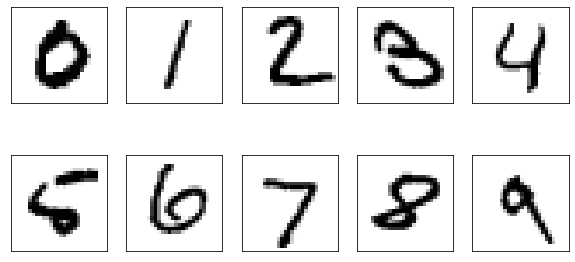

Imagenes perturbación 0.01


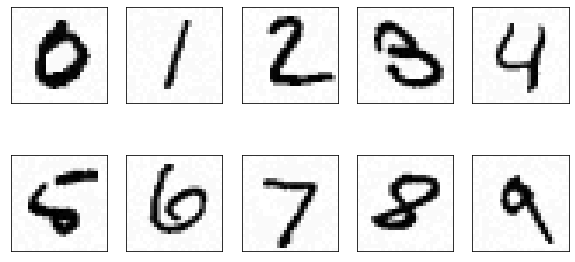

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


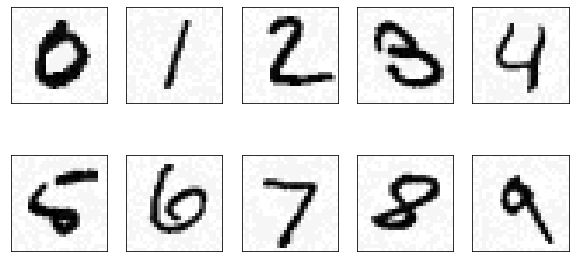

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.03


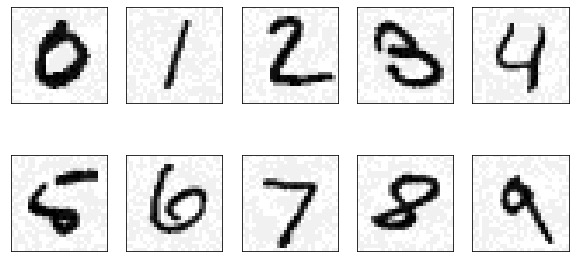

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


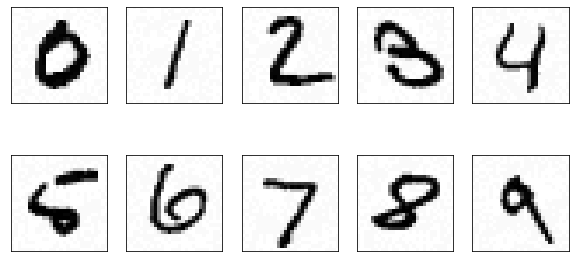

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


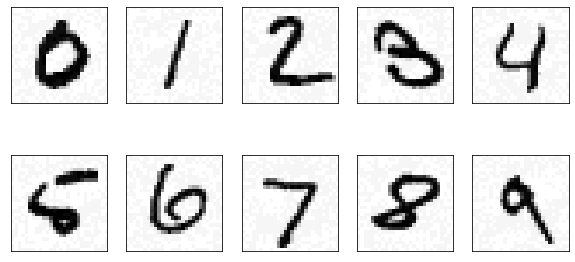

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


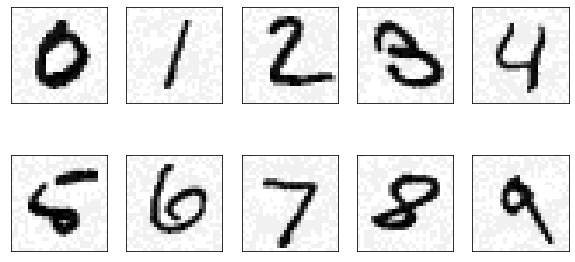

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


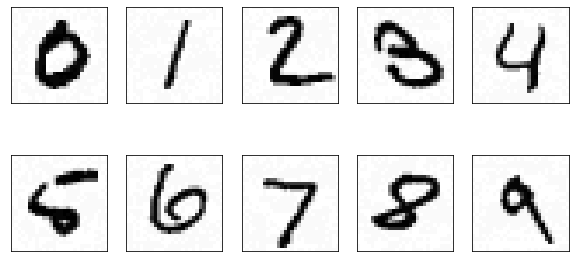

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


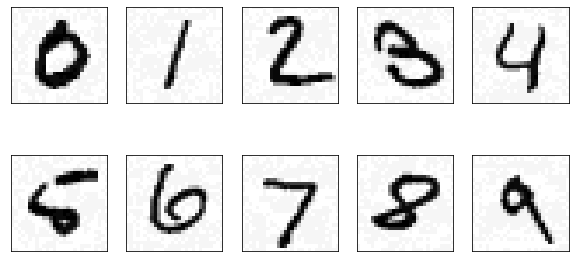

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


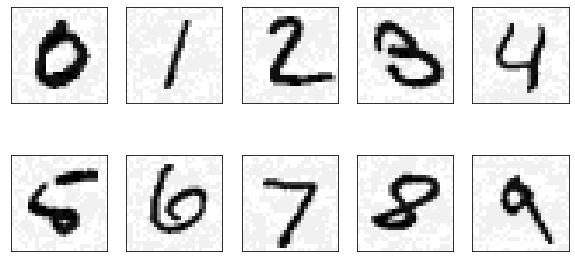

32/32 [==============================] - 0s 3ms/step


In [39]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}
for skip in skips:
  Eval_models_by_rho = {}
  rhos = [0.01, 0.02, 0.03]
  model = modelL2[skip]
  for rho in rhos:
    X_test_atack = np.zeros((1000,784))
    i = 0
    for x_test in X_test[0:1000]:
      x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
      x_tensor1 = tf.expand_dims(x_tensor1, axis=0)
      
      y_tensor1 = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
      y_tensor1 = tf.expand_dims(y_tensor1, axis=0)
    
      y_tensor = y_tensor1
      x_tensor = x_tensor1
      del x_tensor1, y_tensor1
      
      x = tf.Variable(x_tensor)
      y = tf.Variable(y_tensor)
      del x_tensor, y_tensor

      signed_grad = fsgm_attack(x,y,model)

      signo_grad = np.array(signed_grad)
      x_test_new = x_test + rho*signo_grad
      
      X_test_atack[i] = scale_image(x_test_new)
      i +=1 
    print(f'Imagenes perturbación {rho}')
    graph_digits(X_test_atack, y_test[0:1000])
    y_ = model.predict(X_test_atack) # Validation predictions
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_, axis=-1))
    Eval_models_by_rho[rho] = Eval_models
    del Eval_models
  Eval_models_by_rho_skip[skip] = Eval_models_by_rho
  del Eval_models_by_rho

In [40]:
for skip in skips:
  for rho in rhos:
    print(f'Modelo {skip}, perturbación {rho}, % presición {Eval_models_by_rho_skip[skip][rho]*100:0.2f}')

Modelo 4, perturbación 0.01, % presición 78.10
Modelo 4, perturbación 0.02, % presición 50.90
Modelo 4, perturbación 0.03, % presición 23.90
Modelo 6, perturbación 0.01, % presición 73.40
Modelo 6, perturbación 0.02, % presición 50.00
Modelo 6, perturbación 0.03, % presición 29.30
Modelo 8, perturbación 0.01, % presición 82.10
Modelo 8, perturbación 0.02, % presición 64.50
Modelo 8, perturbación 0.03, % presición 45.20


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L1

### Sintonización hiper-parámetro

In [41]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [42]:
param_grid = [ l.l1(0.1), l.l1(0.01), l.l1(0.001), l.l1(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l1}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.10000000149011612
Kfold 1 acc train 0.11337500065565109, acc test 0.10999999940395355
Kfold 2 acc train 0.11287499964237213, acc test 0.1120000034570694
Kfold 3 acc train 0.11249999701976776, acc test 0.11349999904632568
Kfold 4 acc train 0.11150000244379044, acc test 0.11749999970197678
Kfold 5 acc train 0.1132500022649765, acc test 0.11050000041723251
Fin modelo: promedio acc train 0.11270000040531158,std 0.0006736094682305085
Fin modelo: promedio acc test 0.11270000040531158,std 0.002694438425944872


Modelo 4, parametro 0.009999999776482582
Kfold 1 acc train 0.8958749771118164, acc test 0.8634999990463257
Kfold 2 acc train 0.8834999799728394, acc test 0.8769999742507935
Kfold 3 acc train 0.9014999866485596, acc test 0.8920000195503235
Kfold 4 acc train 0.8878750205039978, acc test 0.871999979019165
Kfold 5 acc train 0.8891249895095825, acc test 0.8615000247955322
Fin modelo: promedio acc train 0.8915749907493591,std 0.0063544238330290916
Fin modelo: promedio a

In [43]:
regularParameters = {4: l.l1(0.0001), 6: l.l1(0.001), 8: l.l1(0.001)}
regularParameters

{4: <keras.regularizers.L1 at 0x7f3bfaea82e0>,
 6: <keras.regularizers.L1 at 0x7f3bfaea8ca0>,
 8: <keras.regularizers.L1 at 0x7f3bfaea8cd0>}

### Entrenamiento

In [44]:
skips = [4,6,8]
n_epochs = 60
resultGeneralL1 = {}
modelL1 = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
 
  generator = DataGenerator(images=X_train, 
                            labels=y_train, 
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_model(skip,regularParameters[skip])
  model.compile(optimizer=optimizer, 
                loss = tf.keras.losses.CategoricalCrossentropy(), 
                metrics =['accuracy'])
  
  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))
  
  for epoch in range(n_epochs):
    epoch_acc_avg = tf.keras.metrics.Mean()
    
    for batch in range(n_batches):
      x, y = generator[batch]
      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
        loss += tf.add_n(model.losses)
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test, 
                                                    y_pred=np.argmax(y_test_, axis=-1))

  resultGeneralL1[skip] = [acc_train, acc_test, LB_1]
  modelL1[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL1), 'ResultadosExperimentoAL1adv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [45]:
for skip in skips:
  mean_test = resultGeneralL1[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 92.68
Modelo 6, test 92.62
Modelo 8, test 91.73


### Evaluación en entrenamiento de los modelos

In [46]:
for skip in skips:
  mean_train = resultGeneralL1[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 97.30
Modelo 6, train 97.16
Modelo 8, train 95.81


### Evaluación con imágenes adversarias

Imagenes originales


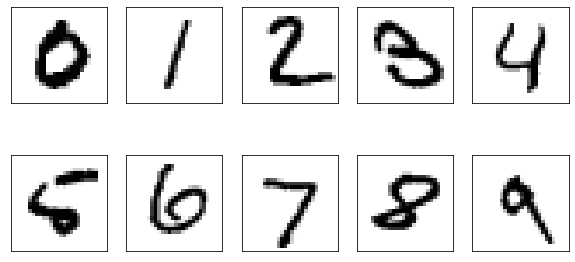

Imagenes perturbación 0.01


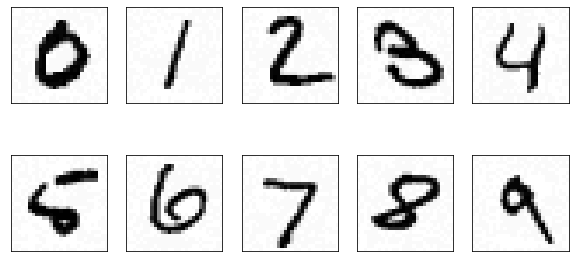

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


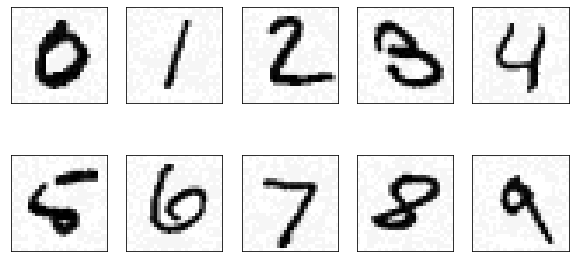

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.03


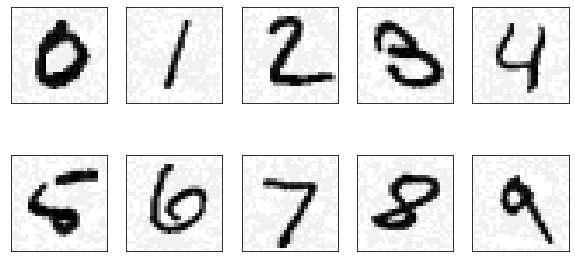

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


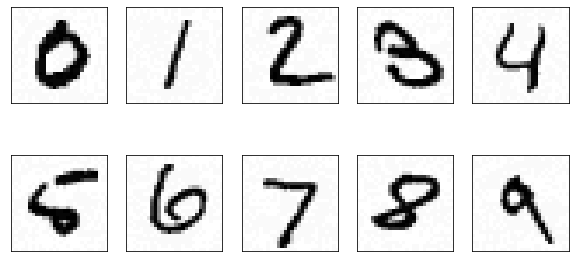

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


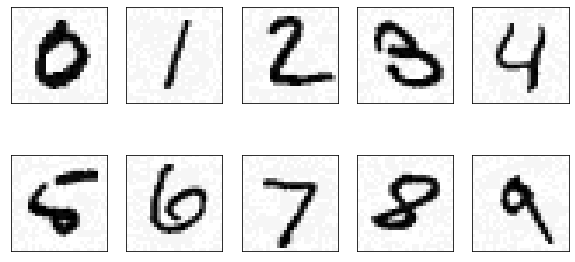

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


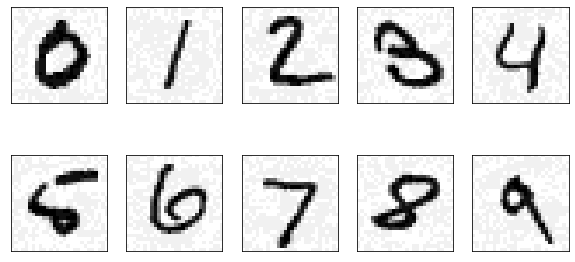

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


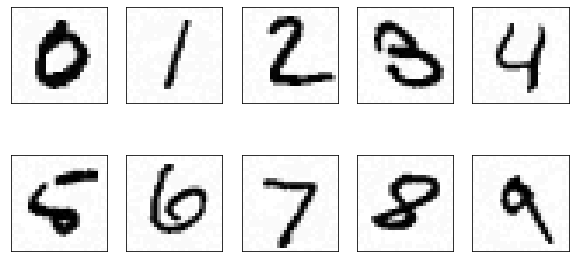

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


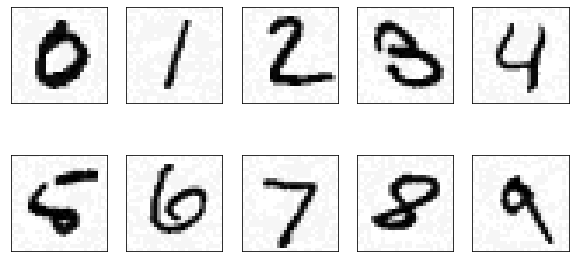

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.03


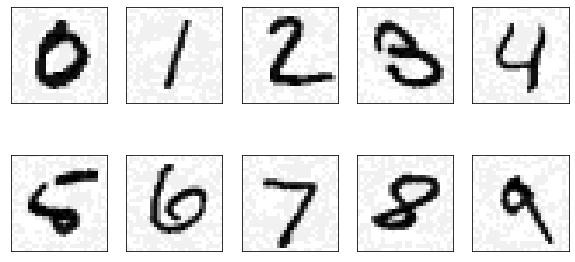

32/32 [==============================] - 0s 1ms/step


In [47]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}
for skip in skips:
  Eval_models_by_rho = {}
  rhos = [0.01, 0.02, 0.03]
  model = modelL1[skip]
  for rho in rhos:
    X_test_atack = np.zeros((1000,784))
    i = 0
    for x_test in X_test[0:1000]:
      x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
      x_tensor1 = tf.expand_dims(x_tensor1, axis=0)
      
      y_tensor1 = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
      y_tensor1 = tf.expand_dims(y_tensor1, axis=0)
    
      y_tensor = y_tensor1
      x_tensor = x_tensor1
      del x_tensor1, y_tensor1
      
      x = tf.Variable(x_tensor)
      y = tf.Variable(y_tensor)
      del x_tensor, y_tensor

      signed_grad = fsgm_attack(x,y,model)

      signo_grad = np.array(signed_grad)
      x_test_new = x_test + rho*signo_grad
      
      X_test_atack[i] = scale_image(x_test_new)
      i +=1 
    print(f'Imagenes perturbación {rho}')
    graph_digits(X_test_atack, y_test[0:1000])
    y_ = model.predict(X_test_atack) # Validation predictions
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_, axis=-1))
    Eval_models_by_rho[rho] = Eval_models
    del Eval_models
  Eval_models_by_rho_skip[skip] = Eval_models_by_rho
  del Eval_models_by_rho

In [48]:
for skip in skips:
  for rho in rhos:
    print(f'Modelo {skip}, perturbación {rho}, % presición {Eval_models_by_rho_skip[skip][rho]*100:0.2f}')

Modelo 4, perturbación 0.01, % presición 73.90
Modelo 4, perturbación 0.02, % presición 46.90
Modelo 4, perturbación 0.03, % presición 21.50
Modelo 6, perturbación 0.01, % presición 81.90
Modelo 6, perturbación 0.02, % presición 66.10
Modelo 6, perturbación 0.03, % presición 45.10
Modelo 8, perturbación 0.01, % presición 80.00
Modelo 8, perturbación 0.02, % presición 61.10
Modelo 8, perturbación 0.03, % presición 39.00


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método *Dropout*

### Modelo DropOut

In [49]:
from keras.layers.regularization.dropout import Dropout

def skip_conectionDropOut(dense_input, n, regular_l, probabilityDrop):
  if n >= 2:
    resDense = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
    resDenseDropOut = Dropout((probabilityDrop))(resDense)
    return skip_conection(Add()([dense_input, resDenseDropOut]), n-1, regular_l)
  resDenseo = Dense(20, activation ='relu', kernel_regularizer=regular_l)(dense_input)
  resDenseoDropOut = Dropout((probabilityDrop))(resDenseo)
  return Add()([dense_input, resDenseo])

In [50]:
def load_modelDropOut(n, regular_l, probabilityDrop):
  keras.backend.clear_session()
  inputs  = Input(shape=(784,))
  dense1  = Dense(20,  activation  ='relu', kernel_regularizer=regular_l)(inputs)
  dense1DropOut = Dropout((probabilityDrop))(dense1)
  skip_final = skip_conectionDropOut(dense1DropOut, n, regular_l, probabilityDrop)

  outputs = Dense(10, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

### Sintonización hiper-parámetro

In [51]:
skips = [4, 6, 8]
kf = KFold(n_splits=5, shuffle=False)

In [52]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_modelDropOut(skip, l.l2(0), param)
      model.compile(loss='categorical_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train_onehot[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train_onehot[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 4, parametro 0.2
Kfold 1 acc train 0.9818750023841858, acc test 0.9194999933242798
Kfold 2 acc train 0.9763749837875366, acc test 0.934499979019165
Kfold 3 acc train 0.972000002861023, acc test 0.9225000143051147
Kfold 4 acc train 0.9796249866485596, acc test 0.9294999837875366
Kfold 5 acc train 0.9753749966621399, acc test 0.9154999852180481
Fin modelo: promedio acc train 0.977049994468689,std 0.0034256374128069345
Fin modelo: promedio acc test 0.9242999911308288,std 0.006852731953505545


Modelo 4, parametro 0.4
Kfold 1 acc train 0.8653749823570251, acc test 0.8195000290870667
Kfold 2 acc train 0.9470000267028809, acc test 0.9164999723434448
Kfold 3 acc train 0.9522500038146973, acc test 0.9085000157356262
Kfold 4 acc train 0.956250011920929, acc test 0.9164999723434448
Kfold 5 acc train 0.9383749961853027, acc test 0.890500009059906
Fin modelo: promedio acc train 0.931850004196167,std 0.03377143050666077
Fin modelo: promedio acc test 0.8902999997138977,std 0.03665185823193100

In [53]:
regularParameters = {4: 0.2, 6: 0.2, 8: 0.2}
regularParameters

{4: 0.2, 6: 0.2, 8: 0.2}

### Entrenamiento

In [54]:
skips = [4,6,8]
n_epochs = 60
resultGeneralDO = {}
modelDO = {}

for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.CategoricalCrossentropy()

  print(f'Modelo : {skip} saltos residuales')
  print(f'\n ----')
  
  generator = DataGenerator(images=X_train, 
                            labels=y_train, 
                            batch_size=100, shuffle=True)
  n_batches = len(generator)
  print(n_batches)
  model = load_modelDropOut(skip,l.l2(0),regularParameters[skip])
  model.compile(optimizer=optimizer, 
                loss = tf.keras.losses.CategoricalCrossentropy(), 
                metrics =['accuracy'])
  
  acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
  LB_1 = np.zeros(shape=(n_epochs,))

  for epoch in range(n_epochs):   
    epoch_acc_avg = tf.keras.metrics.Mean()
    
    for batch in range(n_batches):
      x, y = generator[batch]
      
      with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = ce_loss(y_true=keras.utils.to_categorical(y, num_classes=10), y_pred=y_)
      
      grad = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
      epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
    generator.on_epoch_end()
    acc_train[epoch] = epoch_acc_avg.result()
    LB_1[epoch] = lipschitz_bound(model.get_weights())

  y_test_ = model(X_test)
  acc_test = sklearn.metrics.accuracy_score(y_true=y_test, 
                                                    y_pred=np.argmax(y_test_, axis=-1))

  resultGeneralDO[skip] = [acc_train, acc_test, LB_1]
  modelDO[skip] = model
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralDO), 'ResultadosExperimentoADOadv.csv')

Modelo : 4 saltos residuales

 ----
100
Modelo : 6 saltos residuales

 ----
100
Modelo : 8 saltos residuales

 ----
100


### Evaluación en test de los modelos

In [55]:
for skip in skips:
  mean_test = resultGeneralDO[skip][1]
  print(f'Modelo {skip}, test {mean_test*100:0.2f}')

Modelo 4, test 90.80
Modelo 6, test 91.73
Modelo 8, test 90.68


### Evaluación en entrenamiento de los modelos

In [56]:
for skip in skips:
  mean_train = resultGeneralDO[skip][0][-1]
  print(f'Modelo {skip}, train {mean_train*100:0.2f}')

Modelo 4, train 88.86
Modelo 6, train 90.83
Modelo 8, train 88.88


### Evaluación con imágenes adversarias

Imagenes originales


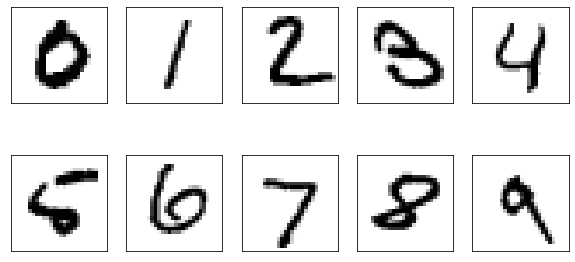

Imagenes perturbación 0.01


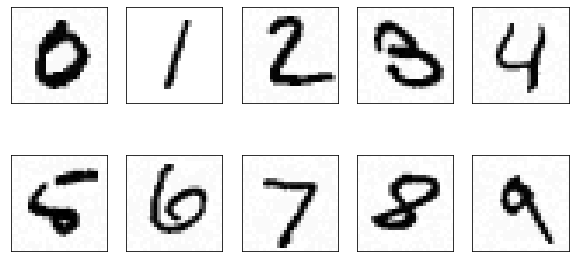

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.02


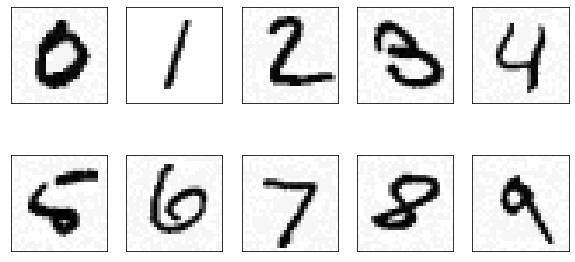

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


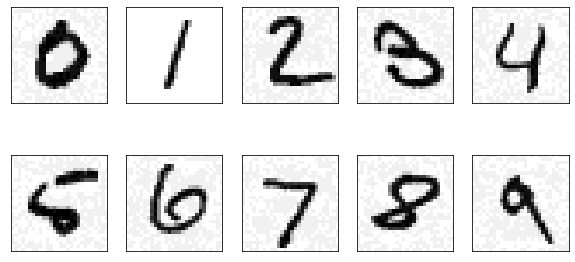

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


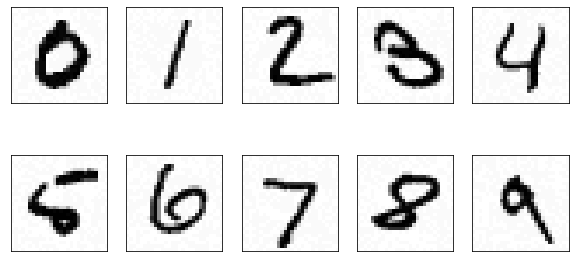

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.02


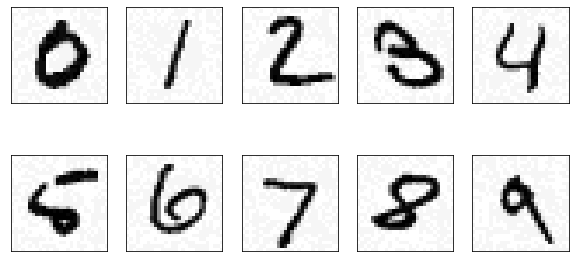

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.03


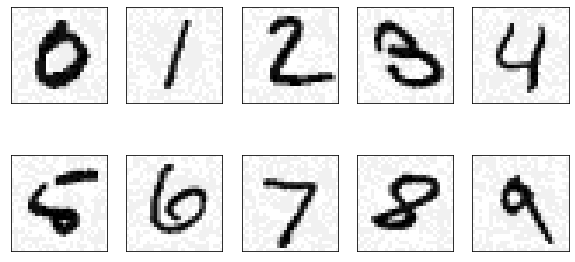

32/32 [==============================] - 0s 1ms/step
Imagenes perturbación 0.01


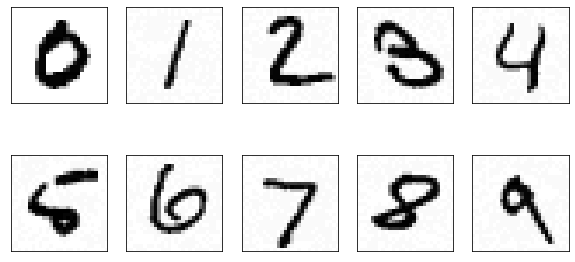

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.02


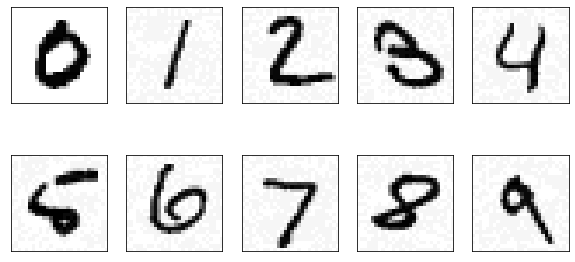

32/32 [==============================] - 0s 2ms/step
Imagenes perturbación 0.03


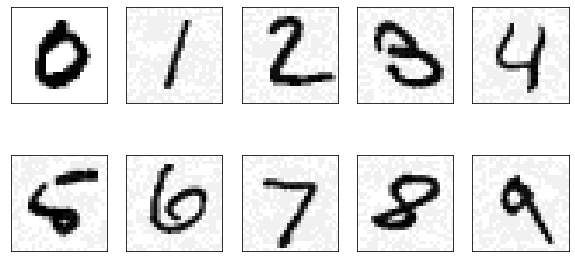

32/32 [==============================] - 0s 2ms/step


In [57]:
print("Imagenes originales")
graph_digits(X_test[0:1000], y_test[0:1000])
loss_function = keras.losses.categorical_crossentropy
Eval_models_by_rho_skip = {}
for skip in skips:
  Eval_models_by_rho = {}
  rhos = [0.01, 0.02, 0.03]
  model = modelDO[skip]
  for rho in rhos:
    X_test_atack = np.zeros((1000,784))
    i = 0
    for x_test in X_test[0:1000]:
      x_tensor1 = tf.convert_to_tensor(x_test, dtype='float32')
      x_tensor1 = tf.expand_dims(x_tensor1, axis=0)
      
      y_tensor1 = tf.convert_to_tensor(y_test_onehot[i], dtype='float32')
      y_tensor1 = tf.expand_dims(y_tensor1, axis=0)
    
      y_tensor = y_tensor1
      x_tensor = x_tensor1
      del x_tensor1, y_tensor1
      
      x = tf.Variable(x_tensor)
      y = tf.Variable(y_tensor)
      del x_tensor, y_tensor

      signed_grad = fsgm_attack(x,y,model)

      signo_grad = np.array(signed_grad)
      x_test_new = x_test + rho*signo_grad
      
      X_test_atack[i] = scale_image(x_test_new)
      i +=1 
    print(f'Imagenes perturbación {rho}')
    graph_digits(X_test_atack, y_test[0:1000])
    y_ = model.predict(X_test_atack) # Validation predictions
    Eval_models = sklearn.metrics.accuracy_score(y_true=y_test[0:1000], y_pred=np.argmax(y_, axis=-1))
    Eval_models_by_rho[rho] = Eval_models
    del Eval_models
  Eval_models_by_rho_skip[skip] = Eval_models_by_rho
  del Eval_models_by_rho

In [58]:
for skip in skips:
  for rho in rhos:
    print(f'Modelo {skip}, perturbación {rho}, % presición {Eval_models_by_rho_skip[skip][rho]*100:0.2f}')

Modelo 4, perturbación 0.01, % presición 76.10
Modelo 4, perturbación 0.02, % presición 56.80
Modelo 4, perturbación 0.03, % presición 41.40
Modelo 6, perturbación 0.01, % presición 77.50
Modelo 6, perturbación 0.02, % presición 60.00
Modelo 6, perturbación 0.03, % presición 44.40
Modelo 8, perturbación 0.01, % presición 68.20
Modelo 8, perturbación 0.02, % presición 45.90
Modelo 8, perturbación 0.03, % presición 29.40
